In [1]:
import matplotlib.pyplot as plt

In [32]:
import gym
from gym import spaces
import numpy as np
import pandas as pd



def get_dataset(path="data/european_wholesale_electricity_price_data_hourly.csv", year="2016",country="Germany", usecols=["Datetime (Local)", "Price (EUR/MWhe)", "Country"]):
    df = pd.read_csv(path,usecols=usecols)
    df = df[df.Country == country]
    df = df[df["Datetime (Local)"] > "2020-01-01 00:00:00"]
    df.drop(["Country"], axis=1, inplace=True)
    df.rename({"Datetime (Local)": "timestamp",
                "Price (EUR/MWhe)": "price"}, axis=1,inplace=True,errors="raise")
    df.price = df.price 
    df = df.reset_index()
    return df


class Battery(gym.Env):

    def __init__(self, render_mode=None, df=None, k=5, NEC=10**5):

        self.NEC = NEC
        self.E1H = NEC/2
        self.k = k
        self.df = df if len(df)>0 else get_dataset()
        self.df["mean_price"] = self.df.price.rolling(self.k).mean()
        self.price = self.df.price.to_numpy()
        self.mean_price = self.df.mean_price.to_numpy()
        self.n_hours = len(self.df)
        self.SOC = np.zeros(self.n_hours)

        self.observation_space = spaces.Box(low=np.array([-1000 for _ in range(k)] + [0.0 for _ in range(k)]), high=np.array([1000 for _ in range(k)] + [1.0 for _ in range(k)]), shape=(k * 2,),dtype=np.float64)

        # We have 3 actions, corresponding to "charge, hold, discharge"
        self.action_space = spaces.Discrete(3)

    def _get_obs(self):
        return np.concatenate([self.price[self.hour-self.k+1:self.hour+1],
                          self.SOC[self.hour-self.k:self.hour]])

    def _get_info(self):
        return None # self.df.loc[self.hour]

    def reset(self, seed=None, options=None):
        self.hour = self.k
        observation = self._get_obs()
        # info = self._get_info()

        return observation

    def step(self, action):
        if action == 0:
            self.SOC[self.hour] = max(
                0,  (self.SOC[self.hour-1]*self.NEC - self.E1H) / self.NEC)

        elif action == 1:
            self.SOC[self.hour] = self.SOC[self.hour-1]

        elif action == 2:
            self.SOC[self.hour] = min(
                1,  (self.SOC[self.hour-1]*self.NEC + self.E1H) / self.NEC)

        reward = (action-1) * \
            (self.mean_price[self.hour] - self.price[self.hour])

        self.hour += 1
        terminated = self.hour == self.n_hours
        obs = self._get_obs() if not terminated else None

        return obs, reward, (self.hour == self.n_hours), {}





In [3]:
df = get_dataset()

In [33]:
bat = Battery(df=df)
bat.reset()
# terminated = False

# reward_list = []
# observation_list = []

# while not terminated :
#     action = bat.action_space.sample()
#     observation, reward, terminated, _, _ = bat.step(action)
#     # assert len(observation[1]) ==5 
#     reward_list.append(reward)
#     observation_list.append(observation)


array([36.55, 32.32, 30.85, 30.14, 30.17,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ])

In [22]:
# bat.reset()
bat.observation_space.sample()

array([ 1.85118388e+02, -5.17648452e+02,  7.52954542e+02, -8.40249487e+02,
        8.92081184e+02,  8.21657144e-01,  9.46999864e-01,  2.59428078e-01,
        7.05342966e-01,  5.28402604e-01])

In [23]:
bat.reset()

array([36.55, 32.32, 30.85, 30.14, 30.17,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ])

In [34]:
from stable_baselines3.common.env_checker import check_env
check_env(bat)

<AxesSubplot: >

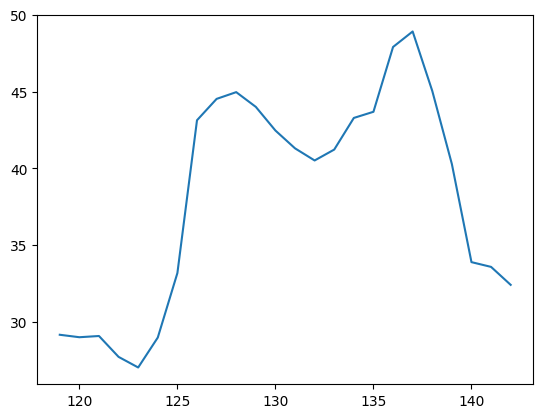

In [38]:
df[24*5-1:24*5+24-1].price.plot(x="timestamp")

In [29]:
import gym

from stable_baselines3 import DQN

In [38]:
len(df)

26304

In [ ]:

training_env = Battery(df=df[:3000])
training_env.reset()
model = DQN("MlpPolicy", training_env, verbose=1)
model.learn(total_timesteps=10000, log_interval=4)
# model.save("dqn_cartpole")

# del model # remove to demonstrate saving and loading

# model = DQN.load("dqn_cartpole")




In [44]:
test_env = Battery(df=df[3000:6000])
obs = test_env.reset()
reward_list = []

while True:
    print(test_env.hour,end="\r")
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _ = test_env.step(action)
    reward_list.append(reward)
    if done : break


C:\Users\Alban\AppData\Local\Temp\ipykernel_14480\2968471596.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["mean_price"] = self.df.price.rolling(self.k).mean()


In [48]:
test_env = Battery(df=df[3000:6000])
obs = test_env.reset()
reward_list = []

while True:
    print(test_env.hour,end="\r")
    action = test_env.action_space.sample()
    obs, reward, done, _ = test_env.step(action)
    reward_list.append(reward)
    if done : break


C:\Users\Alban\AppData\Local\Temp\ipykernel_14480\2968471596.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["mean_price"] = self.df.price.rolling(self.k).mean()


In [49]:
np.mean(reward_list)

0.03350050083472454